<a href="https://colab.research.google.com/github/akramTL/akramTL/blob/main/brain_tumor_classification_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [20]:
# ============================================
# 🧠 Brain Tumor Classification - EfficientNetB3
# ✅ Cell 1: Environment setup for Google Colab
# ============================================

# 1️⃣ Install required packages (if not already)
!pip install tensorflow keras --quiet

# 2️⃣ Import required libraries
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from google.colab import drive

# 3️⃣ Mount Google Drive (to load dataset / save model)
drive.mount('/content/drive')

# 4️⃣ Check GPU availability
print("✅ TensorFlow version:", tf.__version__)
device_name = tf.test.gpu_device_name()
if device_name:
    print("🚀 GPU detected:", device_name)
else:
    print("⚠️ No GPU found — go to Runtime → Change runtime type → GPU")

# 5️⃣ Set base directories (you will update dataset path later)
BASE_DIR = "/content/drive/MyDrive/brain_tumor_dataset"  # <- update this with your dataset path
print("📂 Base directory set to:", BASE_DIR)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ TensorFlow version: 2.19.0
🚀 GPU detected: /device:GPU:0
📂 Base directory set to: /content/drive/MyDrive/brain_tumor_dataset


In [21]:
# ============================================
# 🧠 Download dataset zip from Google Drive
# ============================================

!pip install gdown --quiet

# Replace the file_id below with yours
file_id = "1G58GxM91nTu52Ri-DowYAT0f7jsLXahK"
output = "/content/drive/MyDrive/brain_tumor_dataset.zip"

# Download directly from Drive
!gdown --id {file_id} -O {output}

print("✅ Dataset zip downloaded to:", output)


/usr/local/lib/python3.12/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1G58GxM91nTu52Ri-DowYAT0f7jsLXahK
From (redirected): https://drive.google.com/uc?id=1G58GxM91nTu52Ri-DowYAT0f7jsLXahK&confirm=t&uuid=660791a0-ab28-4abf-99a9-d2145fa9264a
To: /content/drive/MyDrive/brain_tumor_dataset.zip
100% 156M/156M [00:00<00:00, 225MB/s]
✅ Dataset zip downloaded to: /content/drive/MyDrive/brain_tumor_dataset.zip


In [22]:
# ============================================
# 🧠 Cell 1B: Unzip and verify dataset structure
# ============================================

!unzip -q "/content/drive/MyDrive/brain_tumor_dataset.zip" -d "/content/drive/MyDrive/brain_tumor_dataset"

# 📂 List folders after extraction
!ls "/content/drive/MyDrive/brain_tumor_dataset"


replace /content/drive/MyDrive/brain_tumor_dataset/Testing/glioma/Te-glTr_0000.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
replace /content/drive/MyDrive/brain_tumor_dataset/Testing/glioma/Te-glTr_0001.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
replace /content/drive/MyDrive/brain_tumor_dataset/Testing/glioma/Te-glTr_0002.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: Testing  Training


In [23]:
# ============================================
# 🧠 Cell 2: Prepare and split dataset 80/20
# ============================================

import os, shutil
from sklearn.model_selection import train_test_split

# Paths
original_train_dir = "/content/drive/MyDrive/brain_tumor_dataset/Training"
original_test_dir = "/content/drive/MyDrive/brain_tumor_dataset/Testing"
split_base_dir = "/content/brain_tumor_split"
train_dir = os.path.join(split_base_dir, "train")
test_dir = os.path.join(split_base_dir, "test")

# Clean old split if it exists
if os.path.exists(split_base_dir):
    shutil.rmtree(split_base_dir)
os.makedirs(train_dir)
os.makedirs(test_dir)

# We’ll merge both Training and Testing into one combined set, then re-split 80/20
all_classes = os.listdir(original_train_dir)
print("📸 Found classes:", all_classes)

for cls in all_classes:
    cls_train = os.path.join(original_train_dir, cls)
    cls_test = os.path.join(original_test_dir, cls)

    # Combine all images from original Train + Test folders
    all_imgs = []
    if os.path.exists(cls_train):
        all_imgs += [os.path.join(cls_train, img) for img in os.listdir(cls_train)]
    if os.path.exists(cls_test):
        all_imgs += [os.path.join(cls_test, img) for img in os.listdir(cls_test)]

    # Split 80 % train / 20 % test
    train_imgs, test_imgs = train_test_split(all_imgs, test_size=0.2, random_state=42)

    os.makedirs(os.path.join(train_dir, cls), exist_ok=True)
    os.makedirs(os.path.join(test_dir, cls), exist_ok=True)

    # Copy images to new split folders
    for img_path in train_imgs:
        shutil.copy(img_path, os.path.join(train_dir, cls))
    for img_path in test_imgs:
        shutil.copy(img_path, os.path.join(test_dir, cls))

print("✅ Dataset prepared and split 80/20")
print(f"Train directory: {train_dir}")
print(f"Test directory:  {test_dir}")


📸 Found classes: ['glioma', 'meningioma', 'notumor', 'pituitary']
✅ Dataset prepared and split 80/20
Train directory: /content/brain_tumor_split/train
Test directory:  /content/brain_tumor_split/test


In [16]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Augmentation for training data
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=25,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    shear_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Validation/test data (no augmentation)
test_datagen = ImageDataGenerator(rescale=1./255)

# ✅ Use EfficientNetB4 input size (380x380)
train_gen = train_datagen.flow_from_directory(
    train_dir,
    target_size=(380, 380),  # ← changed from (224, 224)
    batch_size=16,           # smaller batch fits better on GPU
    class_mode='categorical'
)

test_gen = test_datagen.flow_from_directory(
    test_dir,
    target_size=(380, 380),
    batch_size=16,
    class_mode='categorical'
)

print("✅ Data generators ready for EfficientNetB4 input size!")


Found 5617 images belonging to 4 classes.
Found 1406 images belonging to 4 classes.
✅ Data generators ready for EfficientNetB4 input size!


In [24]:
# 🧠 Cell 5 — Build & Compile EfficientNetB4 Model (optimized for Colab T4)

from tensorflow.keras.applications import EfficientNetB4
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# ⚙️ 1. Load EfficientNetB4 base model (pretrained on ImageNet)
base_model = EfficientNetB4(
    include_top=False,
    weights='imagenet',
    input_shape=(380, 380, 3)
)

# Freeze base layers for transfer learning
for layer in base_model.layers:
    layer.trainable = False

# 🧱 2. Add custom classification layers
x = layers.GlobalAveragePooling2D()(base_model.output)
x = layers.Dropout(0.45)(x)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(4, activation='softmax')(x)

model = models.Model(inputs=base_model.input, outputs=outputs)

# 🧮 3. Compile the model
model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# 🧩 4. Define Callbacks
checkpoint = ModelCheckpoint(
    '/content/efficientnetb4_brain_tumor_best.keras',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

early_stop = EarlyStopping(
    monitor='val_accuracy',
    patience=6,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.3,
    patience=3,
    min_lr=1e-6,
    verbose=1
)

print("✅ EfficientNetB4 model built successfully for T4 GPU!")
model.summary()


✅ EfficientNetB4 model built successfully for T4 GPU!


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 380, 380,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_8         │ (None, 380, 380,  │          0 │ input_layer_4[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization_4     │ (None, 380, 380,  │          7 │ rescaling_8[0][0] │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_9         │ (None, 380, 380,  │          0 │ normalization_4[… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 381, 381,  │          0 │ rescaling_9[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 190, 190,  │      1,296 │ stem_conv_pad[0]… │
│                     │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 190, 190,  │        192 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 190, 190,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 190, 190,  │        432 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 190, 190,  │        192 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 190, 190,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 48)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 48)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 12)  │        588 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 48)  │        624 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 190, 190,  │          0 │ block1a_activati… │
│ (Multiply)          │ 48)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 190, 190,  │      1,152 │ block1a_se_excit

 Total params: 18,593,891 (70.93 MB)

 Trainable params: 920,068 (3.51 MB)

 Non-trainable params: 17,673,823 (67.42 MB)

In [25]:
history = model.fit(
    train_gen,
    validation_data=test_gen,
    epochs=20,
    callbacks=[checkpoint, early_stop, reduce_lr]
)


Epoch 1/20


KeyboardInterrupt: 

In [26]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [27]:
!ls /content/drive/MyDrive


'archive (4).zip'      brain_tumor_dataset.zip	'Colab Notebooks'
 brain_tumor_dataset   Classroom


In [28]:
# ====================================================
# 📚 Brain Tumor Classification – EfficientNetB3 (Fine-tuned)
# ====================================================

from google.colab import drive
drive.mount('/content/drive')

import os
import zipfile
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
import shutil

# ✅ Path setup
DATASET_PATH = "/content/drive/MyDrive/brain_tumor_dataset"
SPLIT_PATH = "/content/brain_tumor_split"

# ====================================================
# STEP 1: Split dataset into train/test if not already done
# ====================================================
if not os.path.exists(SPLIT_PATH):
    os.makedirs(SPLIT_PATH + "/train")
    os.makedirs(SPLIT_PATH + "/test")

    classes = os.listdir(DATASET_PATH)
    for cls in classes:
        cls_path = os.path.join(DATASET_PATH, cls)
        if os.path.isdir(cls_path):
            imgs = os.listdir(cls_path)
            train_imgs, test_imgs = train_test_split(imgs, test_size=0.2, random_state=42)
            os.makedirs(os.path.join(SPLIT_PATH, "train", cls))
            os.makedirs(os.path.join(SPLIT_PATH, "test", cls))
            for img in train_imgs:
                shutil.copy(os.path.join(cls_path, img), os.path.join(SPLIT_PATH, "train", cls))
            for img in test_imgs:
                shutil.copy(os.path.join(cls_path, img), os.path.join(SPLIT_PATH, "test", cls))
    print("✅ Dataset split into train/test (80/20).")
else:
    print("✅ Dataset split already exists — skipping.")

# ====================================================
# STEP 2: Image generators
# ====================================================
IMAGE_SIZE = 300  # smaller size than 380 for faster training on T4
BATCH_SIZE = 16

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_directory(
    os.path.join(SPLIT_PATH, 'train'),
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

test_gen = test_datagen.flow_from_directory(
    os.path.join(SPLIT_PATH, 'test'),
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

# ====================================================
# STEP 3: Build model
# ====================================================
base_model = EfficientNetB3(weights='imagenet', include_top=False, input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
base_model.trainable = False  # Freeze base for first stage

x = GlobalAveragePooling2D()(base_model.output)
x = Dropout(0.3)(x)
output = Dense(train_gen.num_classes, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=output)

model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

# ====================================================
# STEP 4: Callbacks
# ====================================================
checkpoint = ModelCheckpoint("/content/drive/MyDrive/best_brain_tumor_model.keras",
                             monitor="val_accuracy",
                             save_best_only=True,
                             mode="max",
                             verbose=1)

early_stop = EarlyStopping(monitor="val_accuracy", patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.3, patience=3, min_lr=1e-6)

# ====================================================
# STEP 5: Train base (frozen) model
# ====================================================
history = model.fit(
    train_gen,
    validation_data=test_gen,
    epochs=10,
    callbacks=[checkpoint, early_stop, reduce_lr]
)

# ====================================================
# STEP 6: Fine-tune (unfreeze last 50 layers)
# ====================================================
base_model.trainable = True
for layer in base_model.layers[:-50]:
    layer.trainable = False

model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

fine_tune_history = model.fit(
    train_gen,
    validation_data=test_gen,
    epochs=10,
    callbacks=[checkpoint, early_stop, reduce_lr]
)

print("✅ Fine-tuning complete! Best model saved to Drive.")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Dataset split already exists — skipping.
Found 5617 images belonging to 4 classes.
Found 1406 images belonging to 4 classes.


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 300, 300,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_10        │ (None, 300, 300,  │          0 │ input_layer_5[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization_5     │ (None, 300, 300,  │          7 │ rescaling_10[0][… │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_11        │ (None, 300, 300,  │          0 │ normalization_5[… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 301, 301,  │          0 │ rescaling_11[0][… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 150, 150,  │      1,080 │ stem_conv_pad[0]… │
│                     │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 150, 150,  │        160 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 150, 150,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 150, 150,  │        360 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 150, 150,  │        160 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 150, 150,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 40)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 40)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 10)  │        410 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 40)  │        440 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 150, 150,  │          0 │ block1a_activati… │
│ (Multiply)          │ 40)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 150, 150,  │        960 │ block1a_se_excit

 Total params: 10,789,683 (41.16 MB)

 Trainable params: 6,148 (24.02 KB)

 Non-trainable params: 10,783,535 (41.14 MB)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 0s 425ms/step - accuracy: 0.3244 - loss: 1.3599
Epoch 1: val_accuracy improved from -inf to 0.40043, saving model to /content/drive/MyDrive/best_brain_tumor_model.keras
352/352 ━━━━━━━━━━━━━━━━━━━━ 230s 526ms/step - accuracy: 0.3245 - loss: 1.3598 - val_accuracy: 0.4004 - val_loss: 1.2779 - learning_rate: 1.0000e-04
Epoch 2/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 0s 359ms/step - accuracy: 0.3595 - loss: 1.2894
Epoch 2: val_accuracy improved from 0.40043 to 0.49004, saving model to /content/drive/MyDrive/best_brain_tumor_model.keras
352/352 ━━━━━━━━━━━━━━━━━━━━ 134s 380ms/step - accuracy: 0.3595 - loss: 1.2894 - val_accuracy: 0.4900 - val_loss: 1.2423 - learning_rate: 1.0000e-04
Epoch 3/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 0s 348ms/step - accuracy: 0.4012 - loss: 1.2563
Epoch 3: val_accuracy improved from 0.49004 to 0.51280, saving model to /content/drive/MyDrive/best_brain_tumor_model.keras
352/352 ━━━━━━━━━━━━━━━━━━━━ 134s 380ms/step - accuracy: 0.4012 - los

🔓 Fine-tuning 53 layers of EfficientNetB3
Epoch 1/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step - accuracy: 0.3777 - loss: 1.3162
Epoch 1: val_accuracy did not improve from 0.53485
352/352 ━━━━━━━━━━━━━━━━━━━━ 168s 348ms/step - accuracy: 0.3778 - loss: 1.3160 - val_accuracy: 0.4068 - val_loss: 1.2322 - learning_rate: 1.0000e-05
Epoch 2/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step - accuracy: 0.4309 - loss: 1.1947
Epoch 2: val_accuracy did not improve from 0.53485
352/352 ━━━━━━━━━━━━━━━━━━━━ 81s 231ms/step - accuracy: 0.4309 - loss: 1.1947 - val_accuracy: 0.4395 - val_loss: 1.1467 - learning_rate: 1.0000e-05
Epoch 3/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step - accuracy: 0.4668 - loss: 1.1566
Epoch 3: val_accuracy did not improve from 0.53485
352/352 ━━━━━━━━━━━━━━━━━━━━ 82s 232ms/step - accuracy: 0.4668 - loss: 1.1566 - val_accuracy: 0.4516 - val_loss: 1.1241 - learning_rate: 1.0000e-05
Epoch 4/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step - accuracy: 0.4766 - loss: 1.1390
Epoch 4:

352/352 ━━━━━━━━━━━━━━━━━━━━ 82s 234ms/step - accuracy: 0.4973 - loss: 1.1048 - val_accuracy: 0.5612 - val_loss: 1.0126 - learning_rate: 1.0000e-05
Epoch 8/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step - accuracy: 0.5010 - loss: 1.1093
Epoch 8: val_accuracy did not improve from 0.56117
352/352 ━━━━━━━━━━━━━━━━━━━━ 81s 231ms/step - accuracy: 0.5011 - loss: 1.1093 - val_accuracy: 0.5256 - val_loss: 1.0570 - learning_rate: 1.0000e-05
Epoch 9/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step - accuracy: 0.5114 - loss: 1.0723
Epoch 9: ReduceLROnPlateau reducing learning rate to 2.9999999242136253e-06.

Epoch 9: val_accuracy did not improve from 0.56117
352/352 ━━━━━━━━━━━━━━━━━━━━ 81s 230ms/step - accuracy: 0.5115 - loss: 1.0723 - val_accuracy: 0.5441 - val_loss: 1.0366 - learning_rate: 1.0000e-05
Epoch 10/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step - accuracy: 0.5257 - loss: 1.0665
Epoch 10: val_accuracy did not improve from 0.56117
352/352 ━━━━━━━━━━━━━━━━━━━━ 81s 229ms/step - accuracy: 0.5

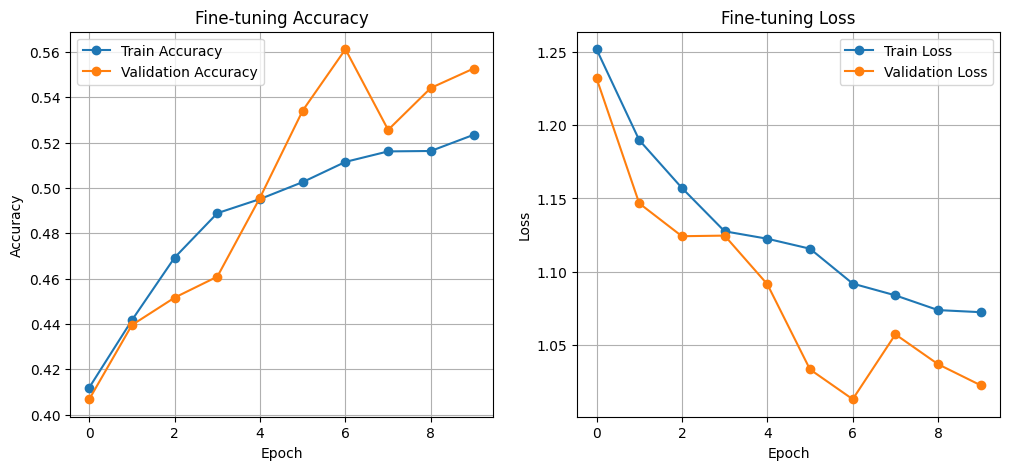

✅ Fine-tuning phase complete — EfficientNetB3 adapted to MRI data.


In [ ]:
# ==============================================================
# 🧠 Cell 6: Fine-Tuning Stage (Unfreeze deeper EfficientNet layers)
# ==============================================================

# Unfreeze the last 50 layers of EfficientNetB3 for fine-tuning
for layer in base_model.layers[-50:]:
    layer.trainable = True

# Recompile with a much lower learning rate
from tensorflow.keras.optimizers import Adam
model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Double-check trainable layers
trainable_count = np.sum([layer.trainable for layer in model.layers])
print(f"🔓 Fine-tuning {trainable_count} layers of EfficientNetB3")

# Train again for 10 epochs
EPOCHS_FINE = 10
history_fine = model.fit(
    train_gen,
    validation_data=test_gen,
    epochs=EPOCHS_FINE,
    batch_size=25,
    callbacks=[early_stop, reduce_lr, checkpoint],
    verbose=1
)

# ==============================================================
# 📊 Plot accuracy/loss comparison for fine-tuning
# ==============================================================

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(history_fine.history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(history_fine.history['val_accuracy'], label='Validation Accuracy', marker='o')
plt.title('Fine-tuning Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1,2,2)
plt.plot(history_fine.history['loss'], label='Train Loss', marker='o')
plt.plot(history_fine.history['val_loss'], label='Validation Loss', marker='o')
plt.title('Fine-tuning Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.show()

print("✅ Fine-tuning phase complete — EfficientNetB3 adapted to MRI data.")


In [ ]:
# ==============================================================
# 🔥 Cell 6: Deep Fine-Tuning EfficientNetB3 (Stage 3)
# ==============================================================

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# ✅ Unfreeze the last 100 layers
for layer in base_model.layers[-100:]:
    layer.trainable = True

# ✅ Re-compile with very low LR
model.compile(
    optimizer=Adam(learning_rate=3e-6),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# ✅ Callbacks
checkpoint = ModelCheckpoint(
    '/content/efficientnetb3_brain_tumor_best_stage3.keras',  # new Keras format
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)
early_stop = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)

# ✅ Train 15 more epochs
history_finetune2 = model.fit(
    train_gen,
    validation_data=test_gen,
    epochs=15,
    callbacks=[checkpoint, early_stop, reduce_lr]
)


Epoch 1/15
352/352 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step - accuracy: 0.3893 - loss: 1.2676
Epoch 1: val_accuracy improved from -inf to 0.44097, saving model to /content/efficientnetb3_brain_tumor_best_stage3.keras
352/352 ━━━━━━━━━━━━━━━━━━━━ 178s 354ms/step - accuracy: 0.3894 - loss: 1.2675 - val_accuracy: 0.4410 - val_loss: 1.1320 - learning_rate: 3.0000e-06
Epoch 2/15
352/352 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step - accuracy: 0.4515 - loss: 1.1968
Epoch 2: val_accuracy improved from 0.44097 to 0.46444, saving model to /content/efficientnetb3_brain_tumor_best_stage3.keras
352/352 ━━━━━━━━━━━━━━━━━━━━ 85s 240ms/step - accuracy: 0.4515 - loss: 1.1967 - val_accuracy: 0.4644 - val_loss: 1.1277 - learning_rate: 3.0000e-06
Epoch 3/15
352/352 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step - accuracy: 0.4602 - loss: 1.1641
Epoch 3: val_accuracy improved from 0.46444 to 0.49858, saving model to /content/efficientnetb3_brain_tumor_best_stage3.keras
352/352 ━━━━━━━━━━━━━━━━━━━━ 85s 242ms/step - accuracy: 0.4602 -